In [1]:
from rosbags.rosbag2 import Reader
from rosbags.serde import deserialize_cdr
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d
import cv2

### Read and show rgb image

In [2]:
rgb_folder = './bagfiles/rgb_folder/'
rgb_file = 'rosbag2_2023_04_14-17_38_27'
# 'rosbag2_2023_04_14-16_28_36'
# 'rosbag2_2023_04_14-16_40_18'
# 'rosbag2_2023_04_14-16_41_33'
# 'rosbag2_2023_04_12-17_57_22'
# 
# 
# 


# create reader instance and open for reading
with Reader(rgb_folder+rgb_file) as reader:
    # topic and msgtype information is available on .connections list
    for connection in reader.connections:
        print(connection.topic, connection.msgtype)

    # iterate over messages
    for connection, timestamp, rawdata in reader.messages():
        if connection.topic == '/color/preview/image':
            img_msg = deserialize_cdr(rawdata, connection.msgtype)
#             print(img_msg.header.frame_id)

/color/preview/image sensor_msgs/msg/Image


(480, 640, 3)

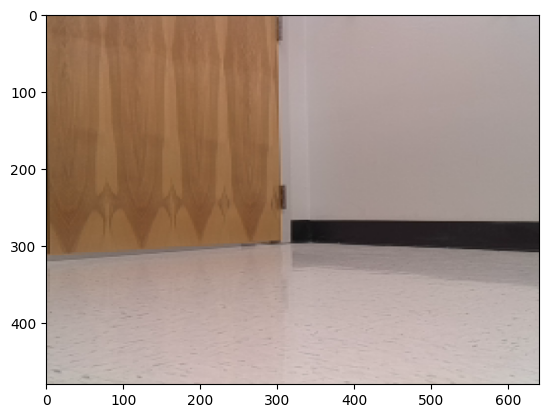

In [3]:
rgb = img_msg.data.reshape(250,250,3)
rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)
# gray = cv2.cvtColor(rgb, cv2.COLOR_BGR2GRAY)
gray = cv2.resize(rgb, (640,480), interpolation = cv2.INTER_AREA)
plt.imshow(gray)
gray.shape

In [4]:
# convert to o3d img
gray_img = o3d.geometry.Image(gray)
gray_img

Image of size 640x480, with 3 channels.
Use numpy.asarray to access buffer data.

### Read and show depth image

In [5]:
depth_folder = './bagfiles/depth_folder/'
depth_file = 'rosbag2_2023_04_14-17_38_37'
# 'rosbag2_2023_04_14-16_41_48'
# 'rosbag2_2023_04_14-16_28_49'
# 'rosbag2_2023_04_14-16_40_29'
# 'rosbag2_2023_04_12-18_02_49'
#
# 


# create reader instance and open for reading
with Reader(depth_folder+depth_file) as reader:
    # topic and msgtype information is available on .connections list
    for connection in reader.connections:
        print(connection.topic, connection.msgtype)

    # iterate over messages
    for connection, timestamp, rawdata in reader.messages():
        if connection.topic == '/stereo/depth':
            depth_msg = deserialize_cdr(rawdata, connection.msgtype)
#             print(depth_msg.header.frame_id)


/stereo/depth sensor_msgs/msg/Image


(480, 640)

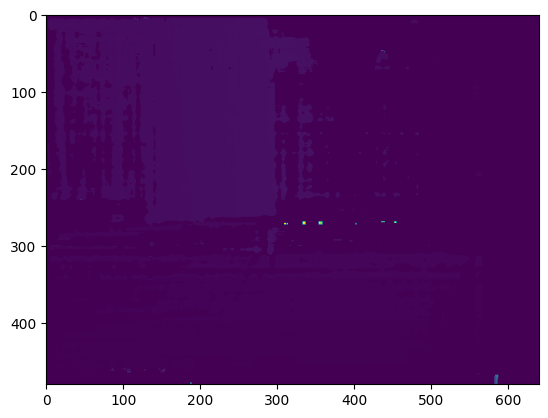

In [6]:
f_depth = np.frombuffer(depth_msg.data, dtype=np.uint16)
f_depth = f_depth.reshape(480,640)
plt.imshow(f_depth)
f_depth.shape

In [7]:
# single_depth = depth_msg.data.reshape(480,640,2)[:,:,0]
# plt.imshow(single_depth)
# single_depth.shape
# f_depth = single_depth.astype(np.uint16)

In [8]:
# convert to o3d img
depth_img = o3d.geometry.Image(f_depth)
depth_img

Image of size 640x480, with 1 channels.
Use numpy.asarray to access buffer data.

In [9]:
# from PIL import Image
# gray = Image.fromarray(gray, "RGB")
# gray.save("./images/rgb1.png")
# f_depth = Image.fromarray(f_depth)
# f_depth.save("./images/depth1.png")

### Create rgbd image

RGBDImage of size 
Color image : 640x480, with 3 channels.
Depth image : 640x480, with 1 channels.
Use numpy.asarray to access buffer data.


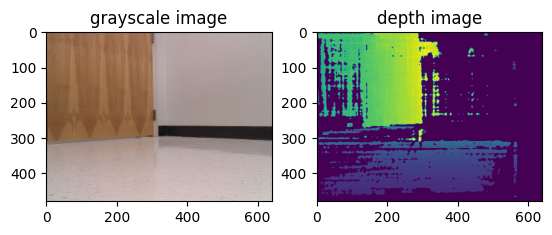

In [10]:
rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(gray_img, depth_img, convert_rgb_to_intensity=False)
print(rgbd)

plt.subplot(1, 2, 1)
plt.title('grayscale image')
plt.imshow(rgbd.color)
plt.subplot(1, 2, 2)
plt.title('depth image')
plt.imshow(rgbd.depth)
plt.show()

### Get pointcloud

In [11]:
'''
Here we use PinholeCameraIntrinsicParameters.PrimeSenseDefault as default camera parameter. 
It has image resolution 640x480, focal length (fx, fy) = (525.0, 525.0), and optical center (cx, cy) = (319.5, 239.5). 
An identity matrix is used as the default extrinsic parameter.
'''
## default option
# cam = o3d.camera.PinholeCameraIntrinsic(
#         o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault)

## current option
cam = o3d.camera.PinholeCameraIntrinsic()
cam.intrinsic_matrix =  [[989.7, 0.00, 320.1] , [0.00, 747.9, 281.1], [0.00, 0.00, 1.00]]


## advanced option
# w, h, fx,fy, cx, cy = 250, 250, 
# intrinsic = o3d.camera.PinholeCameraIntrinsic(w, h, fx,fy, cx, cy)
# intrinsic.intrinsic_matrix = [[fx, 0, cx], [0, fy, cy], [0, 0, 1]]
# cam = o3d.camera.PinholeCameraParameters()
# cam.intrinsic = intrinsic
# cam.extrinsic = np.array([[0., 0., 0., 0.], [0., 0., 0., 0.], [0., 0., 0., 0.], [0., 0., 0., 1.]])
# pcd = o3d.geometry.create_point_cloud_from_rgbd_image(
#     rgbd_image, cam.intrinsic, cam.extrinsic)

pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd, cam)
# Flip it, otherwise the pointcloud will be upside down
pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])

o3d.visualization.draw_geometries([pcd])

'''
Factory function to create a pointcloud from an RGB-D image and a camera. 
Given depth value d at (u, v) image coordinate, the corresponding 3d point is:

z = d / depth_scale
x = (u - cx) * z / fx
y = (v - cy) * z / fy
'''

[Open3D WARNING] GLFW Error: GLX: Failed to create context: GLXBadFBConfig
[Open3D WARNING] Failed to create window
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.


'\nFactory function to create a pointcloud from an RGB-D image and a camera. \nGiven depth value d at (u, v) image coordinate, the corresponding 3d point is:\n\nz = d / depth_scale\nx = (u - cx) * z / fx\ny = (v - cy) * z / fy\n'

In [12]:
## convert to np array
xyz_array = np.asarray(pcd.points)
np.shape(xyz_array)

## save pcl array
pcl_folder = './pcl/'
pcl_file = 'pcl5'
# np.save(pcl_folder+pcl_file, xyz_array)

In [13]:
np.shape(xyz_array)

(120902, 3)

### Detect plane segments

In [14]:
plane_model, inliers = pcd.segment_plane(distance_threshold=0.02,
                                         ransac_n=3,
                                         num_iterations=1000)
[a, b, c, d] = plane_model
print(f"Plane equation: {a:.2f}x + {b:.2f}y + {c:.2f}z + {d:.2f} = 0")

inlier_cloud = pcd.select_by_index(inliers)
inlier_cloud.paint_uniform_color([1.0, 0, 0])
outlier_cloud = pcd.select_by_index(inliers, invert=True)
o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud],
                                  width=1080, height=720, left=10, top=10,
                                  zoom=0.1,
                                  front=[-0.4999, -0.1659, -0.8499],
                                  lookat=[2.1813, 2.0619, 1.0999],
                                  up=[0.1204, 0.9852, 0.1215]
                                 )

Plane equation: 0.01x + 1.00y + 0.08z + 0.12 = 0
[Open3D WARNING] GLFW Error: GLX: Failed to create context: GLXBadFBConfig
[Open3D WARNING] Failed to create window
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.


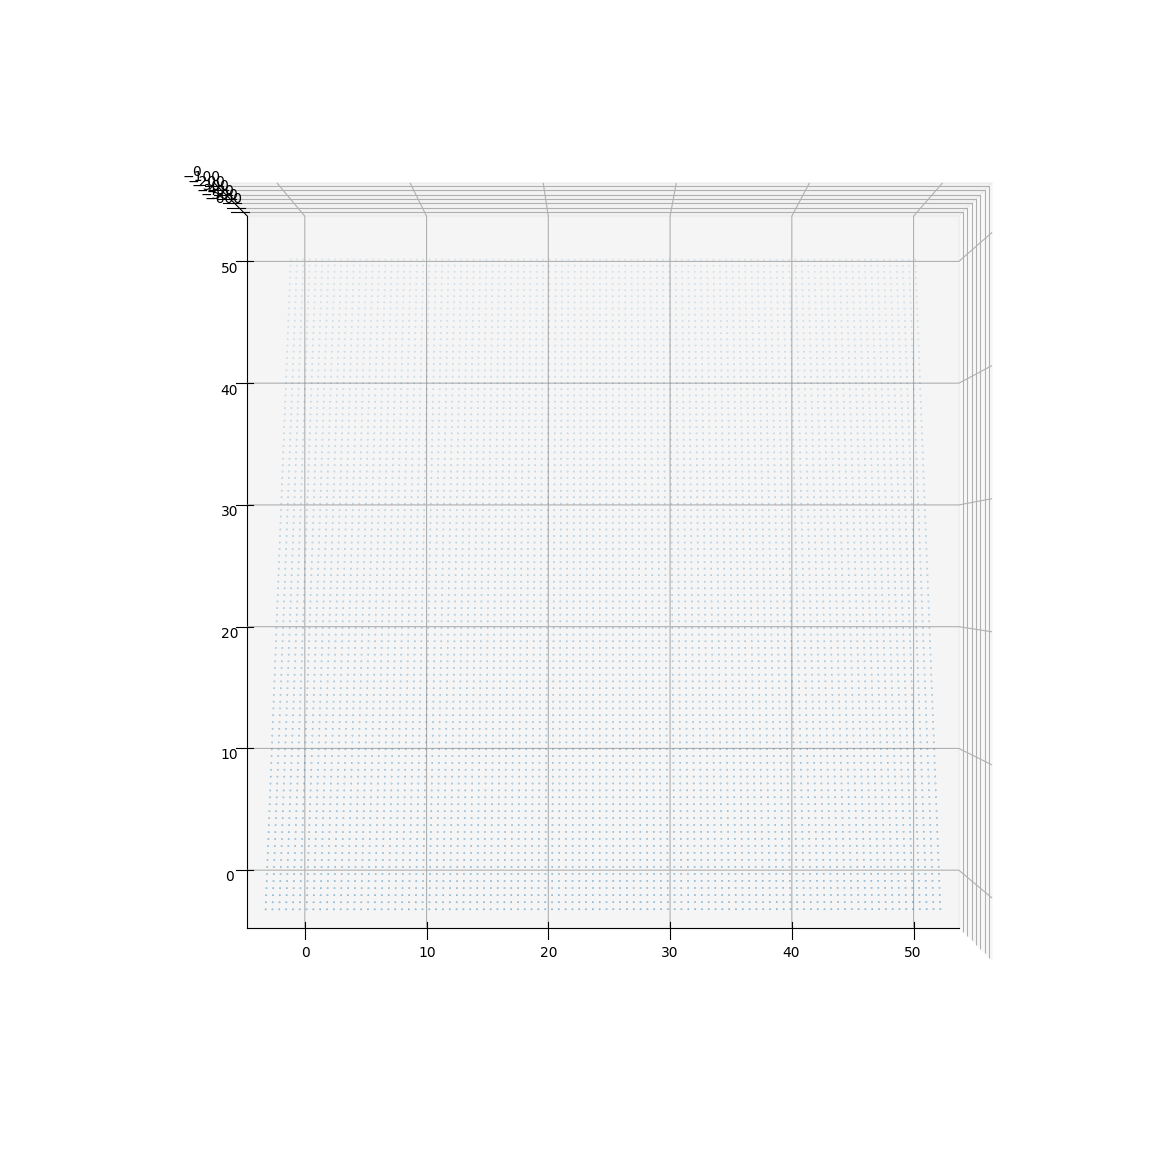

In [24]:
%matplotlib inline
# plt.figure(figsize=(15, 15))
x = np.linspace(-1,50,100)
y = np.linspace(-1,50,100)

X,Y = np.meshgrid(x,y)
Z = (d - a*X - b*Y) / c

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(projection='3d')
ax.view_init(90, -90)
surf = ax.plot_surface(X, Y, Z)
ax = plt.axes(projection='3d')
ax.view_init(90, -90)
# ax.axis("off")
ax.scatter(X, Y, Z, s=0.05) 
plt.show()

In [15]:
outlier_cloud

PointCloud with 65645 points.

In [48]:
# # detect plane patches
# oboxes = pcd.detect_planar_patches(
#     normal_variance_threshold_deg=60,
#     coplanarity_deg=75,
#     outlier_ratio=0.75,
#     min_plane_edge_length=0,
#     min_num_points=0,
#     search_param=o3d.geometry.KDTreeSearchParamKNN(knn=30))

# print("Detected {} patches".format(len(oboxes)))

# geometries = []
# for obox in oboxes:
#     mesh = o3d.geometry.TriangleMesh.create_from_oriented_bounding_box(obox, scale=[1, 1, 0.0001])
#     mesh.paint_uniform_color(obox.color)
#     geometries.append(mesh)
#     geometries.append(obox)
# geometries.append(pcd)

# o3d.visualization.draw_geometries(geometries,
#                                   zoom=0.62,
#                                   front=[0.4361, -0.2632, -0.8605],
#                                   lookat=[2.4947, 1.7728, 1.5541],
#                                   up=[-0.1726, -0.9630, 0.2071])